In [1]:
# ch3/ch3_5_ensemble/ch3_5_3_xgboost/xgboost.ipynb
# 标准库
import sys

# 第三方库
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

# 自定义模块
sys.path.append('./../../../')
import utils.dataset as d
import utils.metrics as m
import utils.plot as p

# 绘图参数
p.set_matplotlib(plot_dpi=80, save_dpi=600, font_size=12)
name_model = 'XGBoost'
name_var = 'PM2.5浓度'
name_unit = ' ($\mu g/m^3$)'


In [2]:
# 数据读取和统计分析
data = pd.read_csv('./../../data/data_pm2_5.csv')
series = data['PM2_5'].values[:, np.newaxis]
ratio_train = 0.8  # 训练样本比例
num_train = int(len(series)*ratio_train)  # 训练样本数量

# 监督学习样本构建
H = 5
S = 1
train = d.series_to_supervised(series[0:num_train], H, S)  # [num_train, H+1]
test = d.series_to_supervised(series[num_train-H:], H, S)  # [num_test, H+1]

# 训练集划分出验证集用于超参数优化
ratio_val = 0.2  # 验证集样本比例
num_val = int(num_train*ratio_val)  # 验证集样本数量
val = train.iloc[-num_val:, :]
train = train.iloc[:-num_val, :]
print(f"{train.shape=}, {val.shape=}, {test.shape=}")

# 样本划分
train_x = train.iloc[:, :-1].values  # [num_train-num_val, H]
train_y = train.iloc[:, -1].values[:, np.newaxis]   # [num_train-num_val, 1]
val_x = val.iloc[:, :-1].values  # [num_val, H]
val_y = val.iloc[:, -1].values[:, np.newaxis]  # [num_val, 1]
test_x = test.iloc[:, :-1].values  # [num_test, H]
test_y = test.iloc[:, -1].values[:, np.newaxis]  # [num_test, 1]
print(f'{train_x.shape=}, {train_y.shape=}')
print(f'{val_x.shape=}, {val_y.shape=}')
print(f'{test_x.shape=}, {test_y.shape=}')

# 样本归一化
x_scalar = MinMaxScaler(feature_range=(0, 1))
y_scalar = MinMaxScaler(feature_range=(0, 1))
train_x_n = x_scalar.fit_transform(train_x)  # [num_train-num_val, H]
val_x_n = x_scalar.transform(val_x)  # [num_val, H]
test_x_n = x_scalar.transform(test_x)  # [num_test, H]
train_y_n = y_scalar.fit_transform(train_y).ravel()  # [num_train-num_val,]
val_y_n = y_scalar.transform(val_y).ravel()  # [num_val,]
test_y_n = y_scalar.transform(test_y).ravel()  # [num_test,]
print(f'{train_x_n.shape=}, {train_y_n.shape=}')
print(f'{val_x_n.shape=}, {val_y_n.shape=}')
print(f'{test_x_n.shape=}, {test_y_n.shape=}')


train.shape=(456, 6), val.shape=(115, 6), test.shape=(144, 6)
train_x.shape=(456, 5), train_y.shape=(456, 1)
val_x.shape=(115, 5), val_y.shape=(115, 1)
test_x.shape=(144, 5), test_y.shape=(144, 1)
train_x_n.shape=(456, 5), train_y_n.shape=(456,)
val_x_n.shape=(115, 5), val_y_n.shape=(115,)
test_x_n.shape=(144, 5), test_y_n.shape=(144,)


In [3]:
# 训练参数
fit_params = {
    'eval_set': [(val_x_n, val_y_n)],
    'verbose': False
}

# 待搜索超参数
parameter_search = {
    'max_depth': sp_randint(2, 10),
    'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 10],
    'reg_lambda': [0, 1e-1, 1, 2, 5, 10]
}

# XGBoost模型
model = xgb.XGBRegressor(
    random_state=None,
    n_jobs=-1,
    n_estimators=10000,
    early_stopping_rounds=20
)

# 随机搜索
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameter_search,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True,
    random_state=None,
    verbose=True,
    n_jobs=-1
)

# 开始超参搜索
random_search.fit(
    train_x_n,
    train_y_n,
    **fit_params
)
print(f'最优验证集分数为{random_search.best_score_=}')
print(f'对应的模型参数为{random_search.best_params_=}')

# 以最优超参数初始化XGBoost模型
parameter_optimal = random_search.best_params_
model_optimal = xgb.XGBRegressor(**model.get_params())
model_optimal.set_params(**parameter_optimal)

# 得到最优迭代次数
best_iteration = model_optimal.fit(
    train_x_n,
    train_y_n,
    **fit_params
).best_iteration
print(f'最优迭代次数为{best_iteration=}')

# 用包含验证集的全量数据重新训练模型
model_optimal = xgb.XGBRegressor(**model.get_params())
model_optimal.set_params(**parameter_optimal)
model_optimal.set_params(**{'early_stopping_rounds': None})
model_optimal.set_params(**{'n_estimators': best_iteration})
model_optimal.fit(
    np.vstack((train_x_n, val_x_n)),
    np.hstack((train_y_n, val_y_n))
)

# 测试
y_hat_n = model_optimal.predict(test_x_n)
y_hat_n = y_hat_n.reshape(-1, 1)
y_hat = y_scalar.inverse_transform(y_hat_n)  # [num_test, 1]

# 测试集-误差计算
print()
m.all_metrics(y_true=test_y, y_pred=y_hat)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
最优验证集分数为random_search.best_score_=-0.011132451732342032
对应的模型参数为random_search.best_params_={'colsample_bytree': 0.891357273077215, 'max_depth': 6, 'min_child_weight': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.6530455646114453}
最优迭代次数为best_iteration=19

mse=16.825
rmse=4.102
mae=2.903
mape=17.186%
sde=4.099
r2=0.847
pcc=0.921


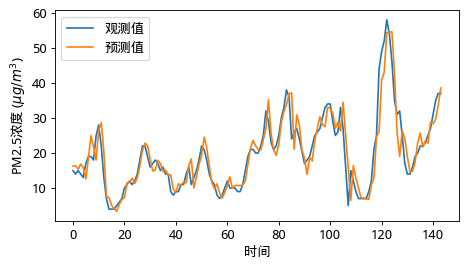

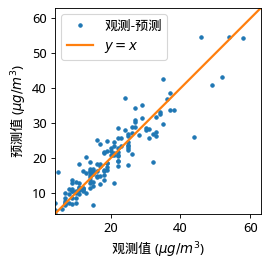

In [4]:
# 可视化
p.plot_results(
    y_true=test_y,
    y_pred=y_hat,
    xlabel='时间',
    ylabel=f'{name_var}{name_unit}',
    fig_name=f'{name_model}_预测曲线'
)
p.plot_parity(
    y_true=test_y,
    y_pred=y_hat,
    xlabel=f'观测值{name_unit}',
    ylabel=f'预测值{name_unit}',
    fig_name=f'{name_model}_Parity'
)
